### Re-visit the OpenSoundScape CNN model training process. 


- So far we've built a training dataset containing human tags of the target species, and inferrred a set of negative samples. 
- These samples still need some human verification to remove mis-labelled samples. 
- This notebook attempts to use OpenSoundScape's methods for training.

The resnet18 model didn't show convergence. 
The resnet 34 model showed convergence. 

The ordering of the labels in the source dataframe was making large differences to the reported metrics. If the absent label is at the 0th index and the present label is at index 1, the metrics look great, but swapping the order of the columns affects the scores. 

If I swapped the order of the labels so that present is at index 1 and absent at index 0, the model no longer converged at all, and would end up predicting 100% of the examples as belonging to the present class. 

During training, there are the same number of positive classes as absent classes. This is true of the validation set used during training too. The full unbalanced validation set contains far more absence than presence, and hence the number of false positives is much higher in the full validation set than in the balanced one. 


I can now check the effect of cleaning the dataset. 

In [1]:
description = "Trains a model with one output neuron"

In [2]:
# !pip install wandb
# ! pip install wandb --upgrade

In [3]:
%env PYTORCH_ENABLE_MPS_FALLBACK 0

env: PYTORCH_ENABLE_MPS_FALLBACK=0


In [4]:
# autoreload
%load_ext autoreload
%autoreload 2

In [5]:
!env |grep MPS


PYTORCH_ENABLE_MPS_FALLBACK=0


In [6]:
!wandb login

wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin


In [124]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import numpy as np
import hashlib
model_save_path = BASE_PATH / 'models'
import matplotlib.pyplot as plt
import torch

In [8]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"


In [9]:
# df_train.sample()

# Log some hyperparameters

In [10]:
n_samples_per_class = 800
one_output_neuron = True
random_seed = 46
learning_rate = 0.01
epochs=10

In [11]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(train_df, target_species = "OSFL", download_n=0, seed=random_seed)

In [12]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# # train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# # valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

# # optionally load these from disk instead

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")



The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [13]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [14]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [15]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

# drop the redundant absence column
balanced_train_df = balanced_train_df.drop(columns=["target_absence"])
balanced_valid_df = balanced_valid_df.drop(columns=["target_absence"])

balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    800
 1.0    800
 Name: count, dtype: int64,
 1600)

In [16]:
balanced_train_df.head()

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-315773.mp3,178.5,181.5,0.0
../../data/raw/recordings/OSFL/recording-296638.mp3,28.5,31.5,0.0
../../data/raw/recordings/OSFL/recording-622379.flac,150.0,153.0,0.0
../../data/raw/recordings/OSFL/recording-291890.mp3,232.5,235.5,0.0
../../data/raw/recordings/OSFL/recording-293408.mp3,31.5,34.5,0.0


In [17]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [18]:
idx=0

In [19]:
shuffled_balanced_train_df = balanced_train_df.sample(frac=1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac=1)

Present label: 1.0
Last clip: 22.5
../../data/raw/recordings/OSFL/recording-50016.flac 151.5 154.5


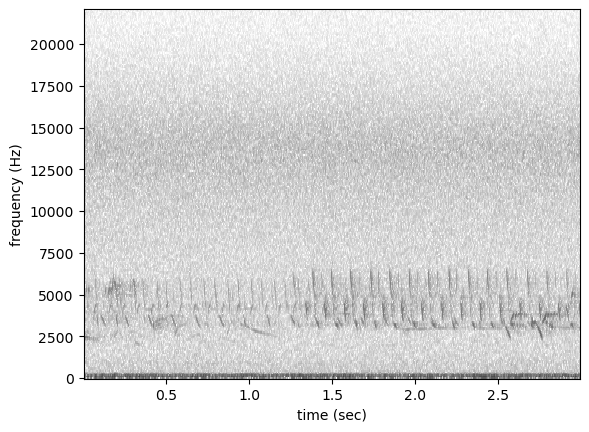

In [20]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [21]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_presence'], dtype='object'),
 Index(['target_presence'], dtype='object'))

In [22]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = False

# model.lr_cooling_factor = 0.1
# model.lr_update_interval = 1
model.classes

['target_presence']

In [23]:
model.optimizer_params['lr'] = learning_rate


In [24]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

In [25]:
class_list

['target_presence']

In [26]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


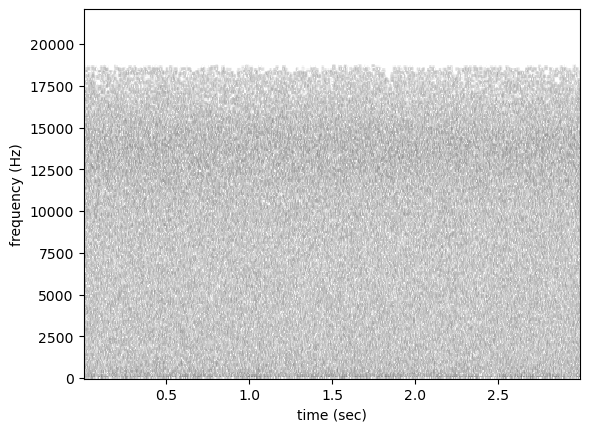

In [27]:
show_sample_from_df(present=True)


In [28]:
print(f'model.device is: {model.device}')

model.device is: mps


In [29]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [30]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    notes=description,
    config={
    "epochs":epochs,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    # "positive_index": positive_index,
    "balanced_valid_set": True,
    
    }
)
wandb.config.learning_rate = learning_rate



wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [31]:
shuffled_balanced_valid_df.value_counts()

target_presence
0.0                500
1.0                500
Name: count, dtype: int64

In [32]:
model.train(
    balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 [batch 0/25, 0.00%] 
	DistLoss: 0.742
Metrics:
Metrics:
	MAP: 0.543

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.654

Training Epoch 1


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 [batch 0/25, 0.00%] 
	DistLoss: 0.671
Metrics:
Metrics:
	MAP: 0.730

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.884

Training Epoch 2


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 2 [batch 0/25, 0.00%] 
	DistLoss: 0.515
Metrics:
Metrics:
	MAP: 0.836

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.912

Training Epoch 3


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 3 [batch 0/25, 0.00%] 
	DistLoss: 0.548
Metrics:
Metrics:
	MAP: 0.858

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.914

Training Epoch 4


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 4 [batch 0/25, 0.00%] 
	DistLoss: 0.446
Metrics:
Metrics:
	MAP: 0.881

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.919

Training Epoch 5


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 5 [batch 0/25, 0.00%] 
	DistLoss: 0.413
Metrics:
Metrics:
	MAP: 0.905

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.936

Training Epoch 6


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 6 [batch 0/25, 0.00%] 
	DistLoss: 0.381
Metrics:
Metrics:
	MAP: 0.915

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.943

Training Epoch 7


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 7 [batch 0/25, 0.00%] 
	DistLoss: 0.462
Metrics:
Metrics:
	MAP: 0.921

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.945

Training Epoch 8


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 8 [batch 0/25, 0.00%] 
	DistLoss: 0.258
Metrics:
Metrics:
	MAP: 0.926

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.933

Training Epoch 9


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 9 [batch 0/25, 0.00%] 
	DistLoss: 0.394
Metrics:
Metrics:
	MAP: 0.934

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.946

Best Model Appears at Epoch 9 with Validation score 0.946.


In [33]:
# model.train(
#     shuffled_balanced_train_df,
#     shuffled_balanced_valid_df,
#     epochs = 4,
#     batch_size = 64,
#     num_workers = 4, #4 parallelized cpu tasks for preprocessing
#     log_interval = 100,
#     save_interval = 10,
#     wandb_session = wandb_session,
#     )

# Too good to be true?
Load the results into notebook 1.21 for sanity check

In [125]:
# save the model too
import datetime
dt = datetime.datetime.now().isoformat()
best_model = opso.cnn.load_model("best.model")
best_model.save(model_save_path / f"osfl_model_single_neuron{dt}")

# Show metrics

In [127]:
model.valid_metrics

{0: {'target_presence': {'au_roc': 0.637124,
   'avg_precision': 0.6542009838801834,
   'precision': 0.6127946127946128,
   'recall': 0.364,
   'f1': 0.4567126725219573,
   'support': 500},
  'precision': 0.5802237644342907,
  'recall': 0.567,
  'f1': 0.5483895864687924,
  'jaccard': 0.38329755302443,
  'hamming_loss': 0.433,
  'map': 0.6542009838801834,
  'au_roc': 0.637124},
 1: {'target_presence': {'au_roc': 0.8539680000000001,
   'avg_precision': 0.8835930434885025,
   'precision': 0.7306501547987616,
   'recall': 0.944,
   'f1': 0.8237347294938918,
   'support': 500},
  'precision': 0.8257770548005108,
  'recall': 0.798,
  'f1': 0.7936003858242293,
  'jaccard': 0.6588604891646435,
  'hamming_loss': 0.202,
  'map': 0.8835930434885025,
  'au_roc': 0.8539680000000001},
 2: {'target_presence': {'au_roc': 0.8949040000000001,
   'avg_precision': 0.911936395763816,
   'precision': 0.8551401869158879,
   'recall': 0.732,
   'f1': 0.7887931034482759,
   'support': 500},
  'precision': 0.81

In [128]:
model.train_metrics

{0: {'target_presence': {'au_roc': 0.5448125,
   'avg_precision': 0.5425067865428146,
   'precision': 0.5098970704671417,
   'recall': 0.805,
   'f1': 0.6243334949103247,
   'support': 800},
  'precision': 0.5234945292988528,
  'recall': 0.515625,
  'f1': 0.47135760057741394,
  'jaccard': 0.3215856384217774,
  'hamming_loss': 0.484375,
  'map': 0.5425067865428146,
  'au_roc': 0.5448125},
 1: {'target_presence': {'au_roc': 0.698365625,
   'avg_precision': 0.7303192465724806,
   'precision': 0.6068052930056711,
   'recall': 0.8025,
   'f1': 0.6910656620021529,
   'support': 800},
  'precision': 0.6576461889382599,
  'recall': 0.64125,
  'f1': 0.6316729204198543,
  'jaccard': 0.4643977996923415,
  'hamming_loss': 0.35875,
  'map': 0.7303192465724806,
  'au_roc': 0.698365625},
 2: {'target_presence': {'au_roc': 0.7986671875000001,
   'avg_precision': 0.8358774910730029,
   'precision': 0.6923837784371909,
   'recall': 0.875,
   'f1': 0.7730535615681944,
   'support': 800},
  'precision': 0

Here we can see how the opso resample operation leaves the dataframe sorted into classes, so suffling is a necessary next step. 

In [129]:
pd.concat([balanced_train_df.tail(), balanced_train_df.head()])

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-255454.mp3,3.0,6.0,1.0
../../data/raw/recordings/OSFL/recording-4503.mp3,133.5,136.5,1.0
../../data/raw/recordings/OSFL/recording-292106.mp3,234.0,237.0,1.0
../../data/raw/recordings/OSFL/recording-622593.flac,3.0,6.0,1.0
../../data/raw/recordings/OSFL/recording-104311.mp3,64.5,67.5,1.0
../../data/raw/recordings/OSFL/recording-315773.mp3,178.5,181.5,0.0
../../data/raw/recordings/OSFL/recording-296638.mp3,28.5,31.5,0.0
../../data/raw/recordings/OSFL/recording-622379.flac,150.0,153.0,0.0
../../data/raw/recordings/OSFL/recording-291890.mp3,232.5,235.5,0.0


In [130]:
model.network.fc

Linear(in_features=512, out_features=1, bias=True)

# Confusion matrix on balanced validation set 
There are equal numbers of examples from each class. 

  0%|          | 0/1000 [00:00<?, ?it/s]

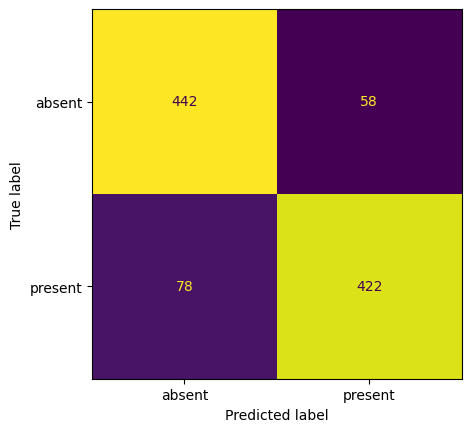

In [133]:
shuf_preds = model.predict(shuffled_balanced_valid_df)
shuf_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(shuf_preds.target_presence.values))
scores = shuf_preds.sigmoid_prediction.values
targets = shuffled_balanced_valid_df.target_presence.values
cm = opso.metrics.M.confusion_matrix(targets, scores.round())
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
cm_display.plot(colorbar=False)

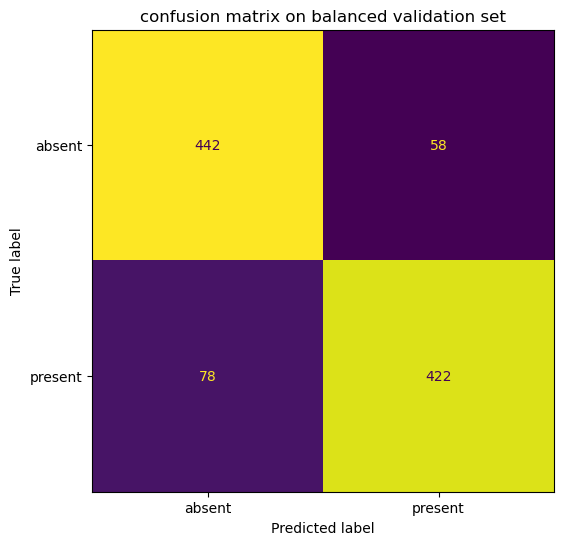

In [123]:
# Plot the confusion matrix and log it to wandb
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("confusion matrix on balanced validation set")
cm_display.plot(ax=ax, colorbar=False)
wandb.log({"Balanced classes confusion matrix": wandb.Image(fig)})

# Make predictions on the full validation set
during training we only looked at a subset of the validation set values. 
http://opensoundscape.org/en/latest/tutorials/predict_with_cnn.html

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:201: UserWarning: The columns of input samples df differ from `model.classes`.
  warnings.warn(


  0%|          | 0/10990 [00:00<?, ?it/s]

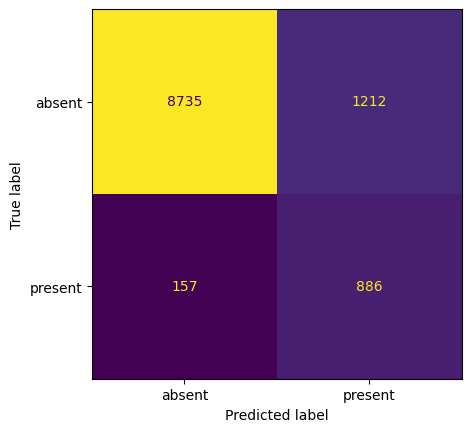

In [139]:
valid_preds = model.predict(valid_df)
valid_preds['sigmoid_prediction'] = torch.sigmoid(torch.tensor(valid_preds.target_presence.values))
scores = valid_preds.sigmoid_prediction.values
targets = valid_df.target_presence.values
cm = opso.metrics.M.confusion_matrix(targets, scores.round())
cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=['absent', 'present'])
cm_display.plot(colorbar=False)

In [140]:
balanced_train_df.sample()

,,,target_presence
file,start_time,end_time,
../../data/raw/recordings/OSFL/recording-100133.flac,15.0,18.0,0.0


In [141]:
model.classes

['target_presence']

In [ ]:
# wandb.finish()

# Result: 

This proves that the model can make good predictions with a single output neuron. 

# Train the model further
This time with a shuffled training set. 

In [142]:
model.train(
    shuffled_balanced_train_df,
    shuffled_balanced_valid_df,
    epochs = epochs,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 10


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 10 [batch 0/25, 0.00%] 
	DistLoss: 0.353
Metrics:
Metrics:
	MAP: 0.944

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.948

Training Epoch 11


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 11 [batch 0/25, 0.00%] 
	DistLoss: 0.295
Metrics:
Metrics:
	MAP: 0.948

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.944

Training Epoch 12


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 12 [batch 0/25, 0.00%] 
	DistLoss: 0.261
Metrics:
Metrics:
	MAP: 0.946

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.950

Training Epoch 13


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 13 [batch 0/25, 0.00%] 
	DistLoss: 0.358
Metrics:
Metrics:
	MAP: 0.953

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.949

Training Epoch 14


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 14 [batch 0/25, 0.00%] 
	DistLoss: 0.193
Metrics:
Metrics:
	MAP: 0.949

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.944

Training Epoch 15


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 15 [batch 0/25, 0.00%] 
	DistLoss: 0.220
Metrics:
Metrics:
	MAP: 0.961

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.949

Training Epoch 16


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 16 [batch 0/25, 0.00%] 
	DistLoss: 0.235
Metrics:
Metrics:
	MAP: 0.962

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.944

Training Epoch 17


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 17 [batch 0/25, 0.00%] 
	DistLoss: 0.388
Metrics:
Metrics:
	MAP: 0.953

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.945

Training Epoch 18


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 18 [batch 0/25, 0.00%] 
	DistLoss: 0.220
Metrics:
Metrics:
	MAP: 0.960

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.927

Training Epoch 19


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 19 [batch 0/25, 0.00%] 
	DistLoss: 0.244
Metrics:
Metrics:
	MAP: 0.960

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:
	MAP: 0.922

Best Model Appears at Epoch 12 with Validation score 0.950.


In [ ]:
# best_model = opso.cnn.load_model("best.model")
# best_model.save(model_save_path / f"osfl_model_iter2_{dt}")

In [ ]:
predictions = best_model.predict(valid_df)
cm = opso.metrics.M.confusion_matrix(np.argmax(valid_df, 1), (np.argmax(predictions, 1)))

cm_display = opso.metrics.M.ConfusionMatrixDisplay(cm, display_labels=best_model.classes)
# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
# add a title
ax.set_title("Confusion matrix on full validation set")
cm_display.plot(ax=ax, colorbar=False)


  0%|          | 0/10990 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_log'

In [ ]:

wandb.finish()


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


epoch,▁▂▃▃▄▅▆▆▇█▁▂▃▃▄▅▆▆▇█▁▁▂▃▃▁▂▃▃▄▅▁▂▃▃▄▅▆▆█
loss,█▇▅▅▄▄▄▄▃▄▃▃▃▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁
epoch,9
loss,0.16362
